<a href="https://colab.research.google.com/github/Yasserashraf1/Ecommerce-Recommendation-System/blob/main/FraudDetectionV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Objective
## This notebook performs a comprehensive exploratory data analysis specifically designed for fraud detection using Isolation Forest. We will focus on identifying:
### - Unusual transaction patterns (quantity, frequency, timing)
### - Anomalous customer behavior (spending spikes, suspicious patterns)
### - Temporal anomalies (unusual order times, rapid consecutive orders)
### - Geographic and demographic outliers
### - Product-level fraud indicators

# 1. Import Libraries


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 2. Load Data


In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

df = pd.read_excel("/content/drive/MyDrive/Renty/GradProject_final_1.xlsx")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (55666, 18)


,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ModelName,ProductDescription,MaritalStatus,Gender,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner,IncomeCategory
0,2020-01-01,2019-09-21,SO45080,332,14657,1,1,1,Road-650,Value-priced bike with many features of our to...,M,M,80000,1,Partial College,Skilled Manual,N,3
1,2021-07-22,2021-05-02,SO51522,485,11000,9,2,2,Fender Set - Mountain,Clip-on fenders fit most mountain bikes.,M,M,90000,2,Bachelors,Professional,Y,3
2,2021-07-22,2021-04-12,SO51522,352,11000,9,1,1,Mountain-200,Serious back-country riding. Perfect for all l...,M,M,90000,2,Bachelors,Professional,Y,3
3,2021-11-04,2021-08-11,SO57418,530,11000,9,3,2,Touring Tire Tube,General purpose tube.,M,M,90000,2,Bachelors,Professional,Y,3
4,2021-11-04,2021-08-10,SO57418,541,11000,9,2,2,Touring Tire,High-density rubber.,M,M,90000,2,Bachelors,Professional,Y,3


# 3. Basic Data Overview


In [37]:
df.info()

df.describe()

print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55666 entries, 0 to 55665
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   OrderDate           55666 non-null  datetime64[ns]
 1   StockDate           55666 non-null  datetime64[ns]
 2   OrderNumber         55666 non-null  object        
 3   ProductKey          55666 non-null  int64         
 4   CustomerKey         55666 non-null  int64         
 5   TerritoryKey        55666 non-null  int64         
 6   OrderLineItem       55666 non-null  int64         
 7   OrderQuantity       55666 non-null  int64         
 8   ModelName           55666 non-null  object        
 9   ProductDescription  55666 non-null  object        
 10  MaritalStatus       55666 non-null  object        
 11  Gender              55666 non-null  object        
 12  AnnualIncome        55666 non-null  int64         
 13  TotalChildren       55666 non-null  int64     

## Convert date columns to datetime


In [38]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['StockDate'] = pd.to_datetime(df['StockDate'])

# 4. Feature Engineering for Fraud Detection
### Creating derived features that are critical for identifying fraudulent patterns:


## Temporal features


In [39]:
df['OrderYear'] = df['OrderDate'].dt.year
df['OrderMonth'] = df['OrderDate'].dt.month
df['OrderDay'] = df['OrderDate'].dt.day
df['OrderDayOfWeek'] = df['OrderDate'].dt.dayofweek
df['OrderHour'] = df['OrderDate'].dt.hour
df['OrderWeek'] = df['OrderDate'].dt.isocalendar().week

## Time difference between order and stock date (negative values are suspicious)


In [40]:
df['OrderToStockDays'] = (df['StockDate'] - df['OrderDate']).dt.days

In [41]:
df['IsWeekend'] = df['OrderDayOfWeek'].isin([5, 6]).astype(int)
df['IsNightOrder'] = df['OrderHour'].between(0, 6).astype(int)

print("Feature engineering completed.")
print(f"New shape: {df.shape}")

Feature engineering completed.
New shape: (55666, 27)


In [42]:
df.head()

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ModelName,ProductDescription,...,IncomeCategory,OrderYear,OrderMonth,OrderDay,OrderDayOfWeek,OrderHour,OrderWeek,OrderToStockDays,IsWeekend,IsNightOrder
0,2020-01-01,2019-09-21,SO45080,332,14657,1,1,1,Road-650,Value-priced bike with many features of our to...,...,3,2020,1,1,2,0,1,-102,0,1
1,2021-07-22,2021-05-02,SO51522,485,11000,9,2,2,Fender Set - Mountain,Clip-on fenders fit most mountain bikes.,...,3,2021,7,22,3,0,29,-81,0,1
2,2021-07-22,2021-04-12,SO51522,352,11000,9,1,1,Mountain-200,Serious back-country riding. Perfect for all l...,...,3,2021,7,22,3,0,29,-101,0,1
3,2021-11-04,2021-08-11,SO57418,530,11000,9,3,2,Touring Tire Tube,General purpose tube.,...,3,2021,11,4,3,0,44,-85,0,1
4,2021-11-04,2021-08-10,SO57418,541,11000,9,2,2,Touring Tire,High-density rubber.,...,3,2021,11,4,3,0,44,-86,0,1


## Interpretation:
### - **OrderToStockDays**: Negative values indicate stock date before order date (highly suspicious)
### - **IsWeekend**: Weekend orders may have different fraud patterns
### - **IsNightOrder**: Orders placed during unusual hours (midnight to 6 AM) may be suspicious


## 5. Customer-Level Behavioral Features

In [43]:
# Calculate customer-level statistics
customer_stats = df.groupby('CustomerKey').agg({
    'OrderNumber': 'count',  # Total orders per customer
    'OrderQuantity': ['sum', 'mean', 'std', 'max'],  # Quantity patterns
    'AnnualIncome': 'first',  # Income (should be constant per customer)
    'ProductKey': 'nunique',  # Product diversity
    'TerritoryKey': 'nunique',  # Territory diversity (suspicious if high)
    'OrderDate': lambda x: (x.max() - x.min()).days  # Customer lifetime in days
}).reset_index()

customer_stats.columns = ['CustomerKey', 'TotalOrders', 'TotalQuantity',
                          'AvgQuantity', 'StdQuantity', 'MaxQuantity',
                          'AnnualIncome', 'UniqueProducts', 'UniqueTerritories',
                          'CustomerLifetimeDays']

In [44]:
# Merge back to main dataframe
df = df.merge(customer_stats, on='CustomerKey', how='left')

print("Customer behavioral features created:")
customer_stats.head()

Customer behavioral features created:


,CustomerKey,TotalOrders,TotalQuantity,AvgQuantity,StdQuantity,MaxQuantity,AnnualIncome,UniqueProducts,UniqueTerritories,CustomerLifetimeDays
0,11000,7,10,1.428571,0.534522,2,90000,7,1,105
1,11001,10,15,1.500000,0.707107,3,60000,9,1,327
2,11002,3,3,1.000000,0.000000,1,60000,3,1,54
3,11003,8,11,1.375000,0.517549,2,70000,8,1,125
4,11004,5,6,1.200000,0.447214,2,80000,5,1,99


## Interpretation:
## These features help identify:
### - **High TotalOrders with low CustomerLifetimeDays**: Velocity abuse (rapid consecutive orders)
### - **High UniqueTerritories**: Potentially stolen accounts being used from different locations
### - **Unusual StdQuantity**: Erratic ordering patterns
### - **MaxQuantity spikes**: Potential bulk fraud orders

# 6. Transaction-Level Anomaly Indicators

In [48]:
if 'AnnualIncome_x' in df.columns:
    # Merge created duplicate columns, use the original
    df['AnnualIncome'] = df['AnnualIncome_x']
    df['QuantityToIncomeRatio'] = (df['OrderQuantity'] * 1000) / (df['AnnualIncome'] + 1)
elif 'AnnualIncome_y' in df.columns:
    df['AnnualIncome'] = df['AnnualIncome_y']
    df['QuantityToIncomeRatio'] = (df['OrderQuantity'] * 1000) / (df['AnnualIncome'] + 1)
else:
    # AnnualIncome exists as-is
    df['QuantityToIncomeRatio'] = (df['OrderQuantity'] * 1000) / (df['AnnualIncome'] + 1)

# Orders per day for each customer
orders_per_day = df.groupby(['CustomerKey', df['OrderDate'].dt.date]).size().reset_index(name='OrdersPerDay')
orders_per_day.columns = ['CustomerKey', 'OrderDate', 'OrdersPerDay']
orders_per_day['OrderDate'] = pd.to_datetime(orders_per_day['OrderDate'])
df = df.merge(orders_per_day, on=['CustomerKey', 'OrderDate'], how='left')

print("\nTransaction-level features created")
print(df[['CustomerKey', 'OrderQuantity', 'AnnualIncome', 'QuantityToIncomeRatio', 'OrdersPerDay']].head(10))



Transaction-level features created
   CustomerKey  OrderQuantity  AnnualIncome  QuantityToIncomeRatio  \
0        14657              1         80000               0.012500   
1        11000              2         90000               0.022222   
2        11000              1         90000               0.011111   
3        11000              2         90000               0.022222   
4        11000              2         90000               0.022222   
5        11000              1         90000               0.011111   
6        11000              1         90000               0.011111   
7        11000              1         90000               0.011111   
8        14734              1         30000               0.033332   
9        14734              1         30000               0.033332   

   OrdersPerDay  
0             1  
1             2  
2             2  
3             5  
4             5  
5             5  
6             5  
7             5  
8             1  
9            

# Interpretation:
## - **QuantityToIncomeRatio**: High values indicate customers ordering unusually large quantities relative to their income (red flag)
## - **OrdersPerDay**: Multiple orders in a single day may indicate automated bot activity or account takeover


# 7. FRAUD INDICATOR ANALYSIS



## 7.1 Distribution of Order Quantities (Key Fraud Indicator)

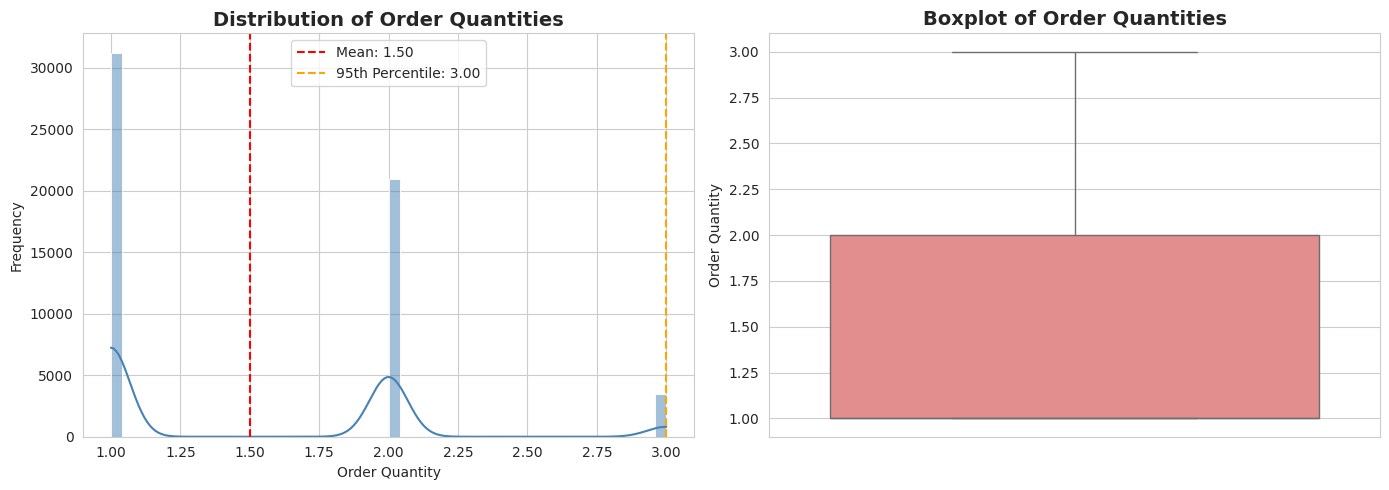


Outlier Statistics for Order Quantity:
Total outliers: 0 (0.00%)
IQR: 1.0
Outlier threshold: > 3.50


In [46]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='OrderQuantity', bins=50, kde=True, color='steelblue')
plt.title('Distribution of Order Quantities', fontsize=14, fontweight='bold')
plt.xlabel('Order Quantity')
plt.ylabel('Frequency')
plt.axvline(df['OrderQuantity'].mean(), color='red', linestyle='--', label=f'Mean: {df["OrderQuantity"].mean():.2f}')
plt.axvline(df['OrderQuantity'].quantile(0.95), color='orange', linestyle='--', label=f'95th Percentile: {df["OrderQuantity"].quantile(0.95):.2f}')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(y=df['OrderQuantity'], color='lightcoral')
plt.title('Boxplot of Order Quantities', fontsize=14, fontweight='bold')
plt.ylabel('Order Quantity')

plt.tight_layout()
plt.show()

# Calculate outlier statistics
Q1 = df['OrderQuantity'].quantile(0.25)
Q3 = df['OrderQuantity'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['OrderQuantity'] < Q1 - 1.5*IQR) | (df['OrderQuantity'] > Q3 + 1.5*IQR)]
print(f"\nOutlier Statistics for Order Quantity:")
print(f"Total outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"IQR: {IQR}")
print(f"Outlier threshold: > {Q3 + 1.5*IQR:.2f}")

#  Interpretation - Order Quantity Anomalies:
## - Most orders are concentrated at low quantities (1-2 items), which is normal behavior
## - The 95th percentile shows the boundary of typical behavior
## - **Outliers above the upper threshold are prime fraud candidates** (unusually large bulk orders)
## - For Isolation Forest, these extreme values will naturally be flagged as anomalies
## - Consider orders with quantity > 2 (95th percentile) for deeper investigation

## 7.2 Order-to-Stock Time Gap Analysis (Critical Fraud Signal)

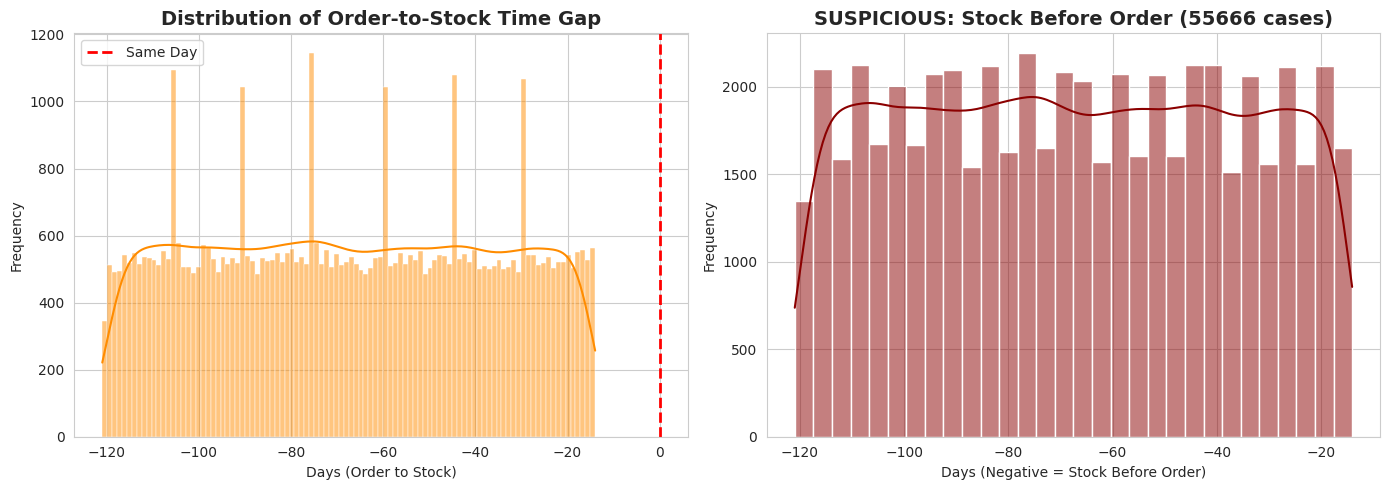


Time Gap Statistics:
Negative gaps (HIGHLY SUSPICIOUS): 55666 (100.00%)
Same day (0 days): 0 (0.00%)
Unusually long gaps (>180 days): 0 (0.00%)

Mean gap: -67.35 days
Median gap: -68.00 days


In [47]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='OrderToStockDays', bins=100, kde=True, color='darkorange')
plt.title('Distribution of Order-to-Stock Time Gap', fontsize=14, fontweight='bold')
plt.xlabel('Days (Order to Stock)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Same Day')
plt.legend()

plt.subplot(1, 2, 2)
negative_days = df[df['OrderToStockDays'] < 0]
sns.histplot(data=negative_days, x='OrderToStockDays', bins=30, kde=True, color='darkred')
plt.title(f'SUSPICIOUS: Stock Before Order ({len(negative_days)} cases)', fontsize=14, fontweight='bold')
plt.xlabel('Days (Negative = Stock Before Order)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nTime Gap Statistics:")
print(f"Negative gaps (HIGHLY SUSPICIOUS): {len(df[df['OrderToStockDays'] < 0])} ({len(df[df['OrderToStockDays'] < 0])/len(df)*100:.2f}%)")
print(f"Same day (0 days): {len(df[df['OrderToStockDays'] == 0])} ({len(df[df['OrderToStockDays'] == 0])/len(df)*100:.2f}%)")
print(f"Unusually long gaps (>180 days): {len(df[df['OrderToStockDays'] > 180])} ({len(df[df['OrderToStockDays'] > 180])/len(df)*100:.2f}%)")
print(f"\nMean gap: {df['OrderToStockDays'].mean():.2f} days")
print(f"Median gap: {df['OrderToStockDays'].median():.2f} days")

### Interpretation - Temporal Anomalies:
# - **CRITICAL FRAUD SIGNAL**: Negative OrderToStockDays means stock date is BEFORE order date (logically impossible in legitimate transactions)
# - These negative gaps likely represent:
#   - Data entry errors (need investigation)
#   - System manipulation or backdated orders (fraud)
#   - Account takeover with historical data tampering
# - Extremely long gaps (>180 days) may indicate:
#   - Abandoned carts later fulfilled fraudulently
#   - Delayed fraud execution
# - For Isolation Forest: These temporal anomalies will be strong fraud indicators

## 7.3 Customer Frequency Analysis (Velocity Abuse Detection)

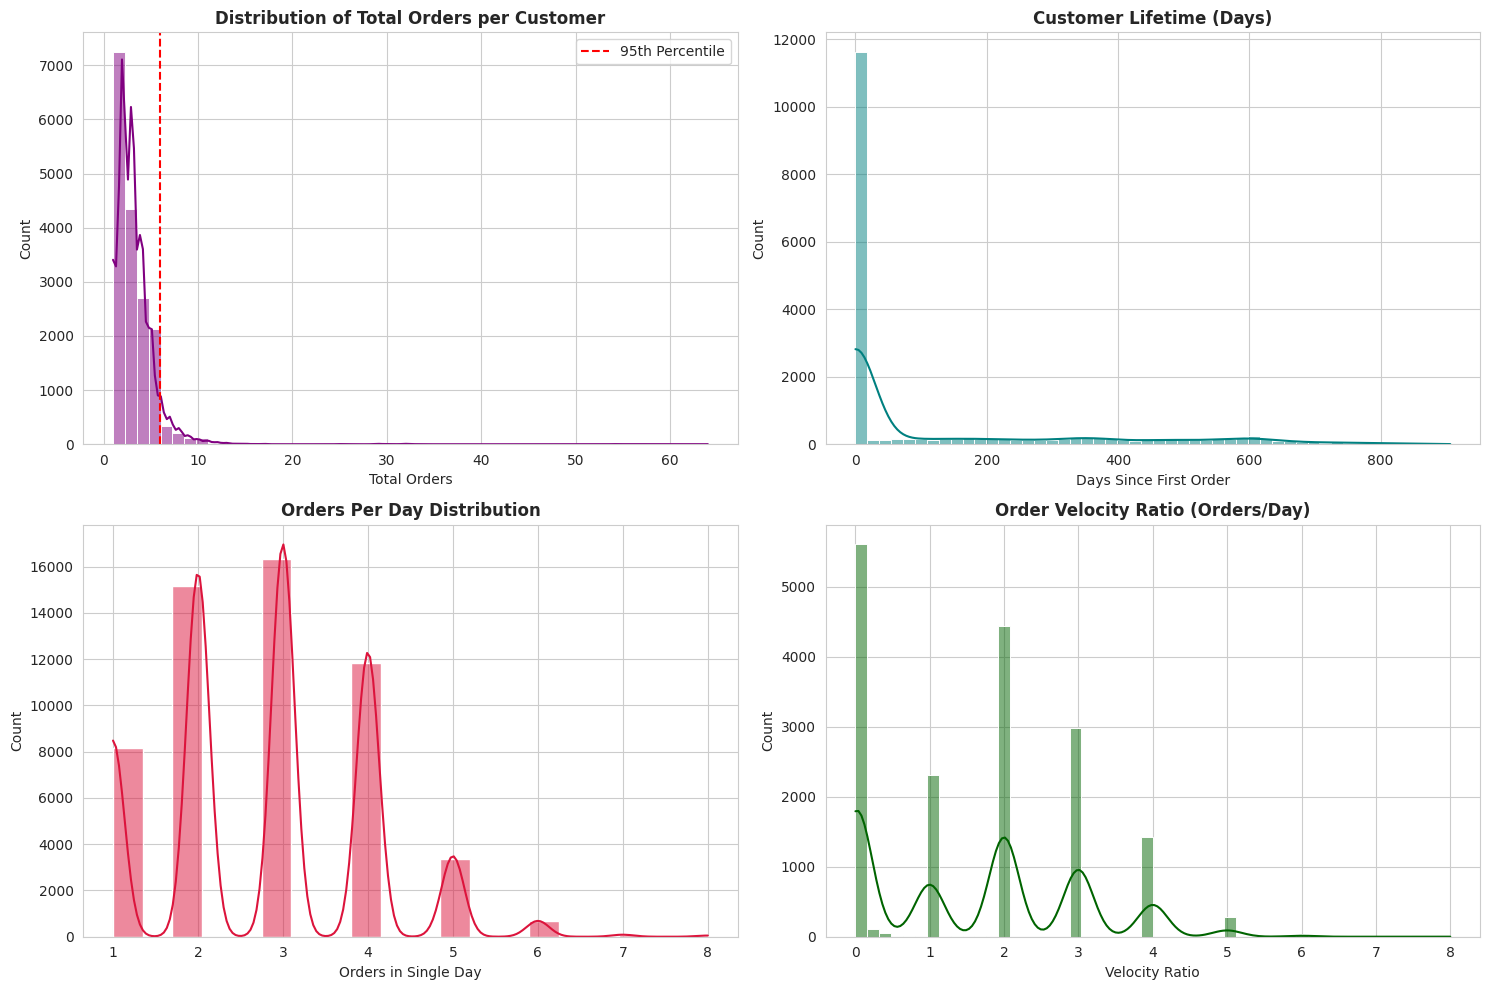


Velocity Abuse Statistics:
High-velocity customers (top 5%): 328
Max velocity ratio: 8.000 orders/day

Customers with >5 orders in single day: 792


In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total orders per customer
sns.histplot(data=customer_stats, x='TotalOrders', bins=50, kde=True, ax=axes[0, 0], color='purple')
axes[0, 0].set_title('Distribution of Total Orders per Customer', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Orders')
axes[0, 0].axvline(customer_stats['TotalOrders'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
axes[0, 0].legend()

# Customer lifetime days
sns.histplot(data=customer_stats, x='CustomerLifetimeDays', bins=50, kde=True, ax=axes[0, 1], color='teal')
axes[0, 1].set_title('Customer Lifetime (Days)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Days Since First Order')

# Orders per day
sns.histplot(data=df, x='OrdersPerDay', bins=20, kde=True, ax=axes[1, 0], color='crimson')
axes[1, 0].set_title('Orders Per Day Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Orders in Single Day')

# Velocity ratio (orders per lifetime day)
customer_stats['VelocityRatio'] = customer_stats['TotalOrders'] / (customer_stats['CustomerLifetimeDays'] + 1)
sns.histplot(data=customer_stats, x='VelocityRatio', bins=50, kde=True, ax=axes[1, 1], color='darkgreen')
axes[1, 1].set_title('Order Velocity Ratio (Orders/Day)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Velocity Ratio')

plt.tight_layout()
plt.show()

print("\nVelocity Abuse Statistics:")
high_velocity = customer_stats[customer_stats['VelocityRatio'] > customer_stats['VelocityRatio'].quantile(0.95)]
print(f"High-velocity customers (top 5%): {len(high_velocity)}")
print(f"Max velocity ratio: {customer_stats['VelocityRatio'].max():.3f} orders/day")
print(f"\nCustomers with >5 orders in single day: {len(df[df['OrdersPerDay'] > 5])}")

# Interpretation - Velocity Abuse Patterns:
# - **High VelocityRatio**: Customers placing many orders in a short time window
#   - May indicate bot activity or automated fraud scripts
#   - Account takeover with rapid asset extraction
# - **Multiple orders per day**: Legitimate customers rarely place >3 orders/day
#   - Exceptions: B2B customers (need special handling)
# - **Short CustomerLifetime with high TotalOrders**: "Hit and run" fraud pattern
# - For Isolation Forest: These velocity metrics are powerful anomaly indicators

## 7.4 Income vs. Spending Behavior (Affordability Anomalies)

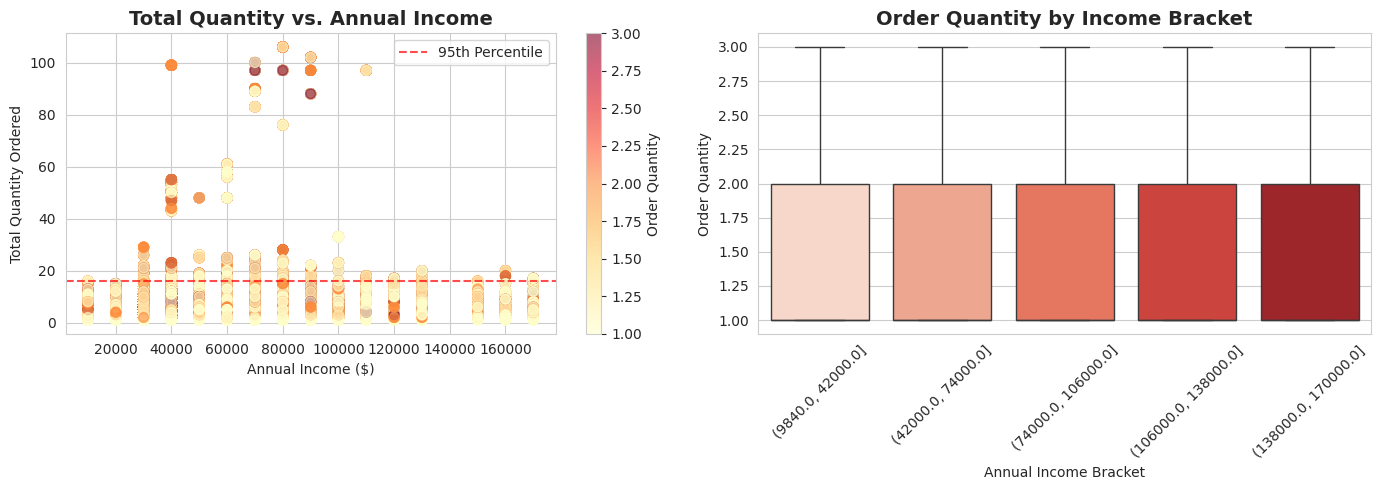


Income-Spending Mismatch Analysis:
Low income but high spenders: 896 (1.61%)
These may indicate:
  - Stolen credit cards being used by low-income fraudsters
  - Account takeover where fraudster profile doesn't match victim
  - Gift card fraud or money laundering


In [50]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(df['AnnualIncome'], df['TotalQuantity'],
                     c=df['OrderQuantity'], cmap='YlOrRd', alpha=0.6, s=50)
plt.colorbar(scatter, label='Order Quantity')
plt.title('Total Quantity vs. Annual Income', fontsize=14, fontweight='bold')
plt.xlabel('Annual Income ($)')
plt.ylabel('Total Quantity Ordered')
plt.axhline(df['TotalQuantity'].quantile(0.95), color='red', linestyle='--', alpha=0.7, label='95th Percentile')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=pd.cut(df['AnnualIncome'], bins=5), y='OrderQuantity', palette='Reds')
plt.title('Order Quantity by Income Bracket', fontsize=14, fontweight='bold')
plt.xlabel('Annual Income Bracket')
plt.ylabel('Order Quantity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Identify suspicious patterns
df['IsLowIncomeHighSpender'] = ((df['AnnualIncome'] < df['AnnualIncome'].quantile(0.25)) &
                                 (df['TotalQuantity'] > df['TotalQuantity'].quantile(0.75))).astype(int)

print("\nIncome-Spending Mismatch Analysis:")
print(f"Low income but high spenders: {df['IsLowIncomeHighSpender'].sum()} ({df['IsLowIncomeHighSpender'].sum()/len(df)*100:.2f}%)")
print(f"These may indicate:")
print("  - Stolen credit cards being used by low-income fraudsters")
print("  - Account takeover where fraudster profile doesn't match victim")
print("  - Gift card fraud or money laundering")



In [ ]:
# ### Interpretation - Income-Spending Anomalies:
# - **Low income + High spending**: Classic fraud indicator
#   - Stolen payment methods used by perpetrators with different financial profiles
#   - Account takeover: fraudster's income doesn't match victim's spending power
# - **Unusual clusters**: Data points far from the income-spending trend line
# - For Isolation Forest: Income-to-spending ratio is a key feature for detecting financial anomalies

## 7.5 Geographic Anomalies (Territory Diversity)

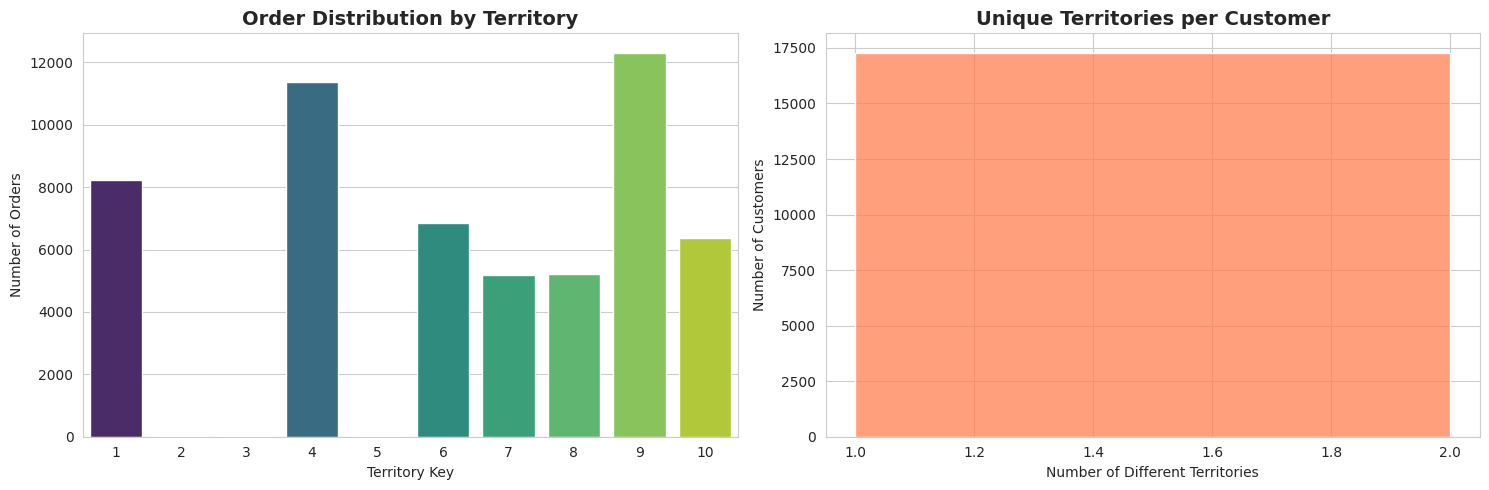


Geographic Anomaly Statistics:
Customers ordering from multiple territories: 0 (0.00%)
Max territories per customer: 1

Potential indicators:
  - Multiple territories may suggest account sharing (against ToS)
  - Could indicate VPN/proxy usage to mask location
  - May represent legitimate business accounts (B2B)


In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Territory distribution
territory_counts = df['TerritoryKey'].value_counts()
sns.barplot(x=territory_counts.index, y=territory_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Order Distribution by Territory', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Territory Key')
axes[0].set_ylabel('Number of Orders')

# Unique territories per customer
sns.histplot(data=customer_stats, x='UniqueTerritories', bins=range(1, customer_stats['UniqueTerritories'].max()+2),
             kde=False, ax=axes[1], color='coral')
axes[1].set_title('Unique Territories per Customer', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Different Territories')
axes[1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

multi_territory = customer_stats[customer_stats['UniqueTerritories'] > 1]
print(f"\nGeographic Anomaly Statistics:")
print(f"Customers ordering from multiple territories: {len(multi_territory)} ({len(multi_territory)/len(customer_stats)*100:.2f}%)")
print(f"Max territories per customer: {customer_stats['UniqueTerritories'].max()}")
print(f"\nPotential indicators:")
print("  - Multiple territories may suggest account sharing (against ToS)")
print("  - Could indicate VPN/proxy usage to mask location")
print("  - May represent legitimate business accounts (B2B)")




#  Interpretation - Geographic Red Flags:
## - **Multiple territories per customer**: Suspicious unless B2B account
#   - Account takeover: fraudster accessing from different location
#   - VPN/proxy usage to hide true location
#   - Reselling or account sharing schemes
# - **Unusual territory concentrations**: Some territories may be fraud hotspots
# - For Isolation Forest: Territory diversity is a behavioral anomaly signal

## 7.6 Product Diversity and Unusual Product Combinations

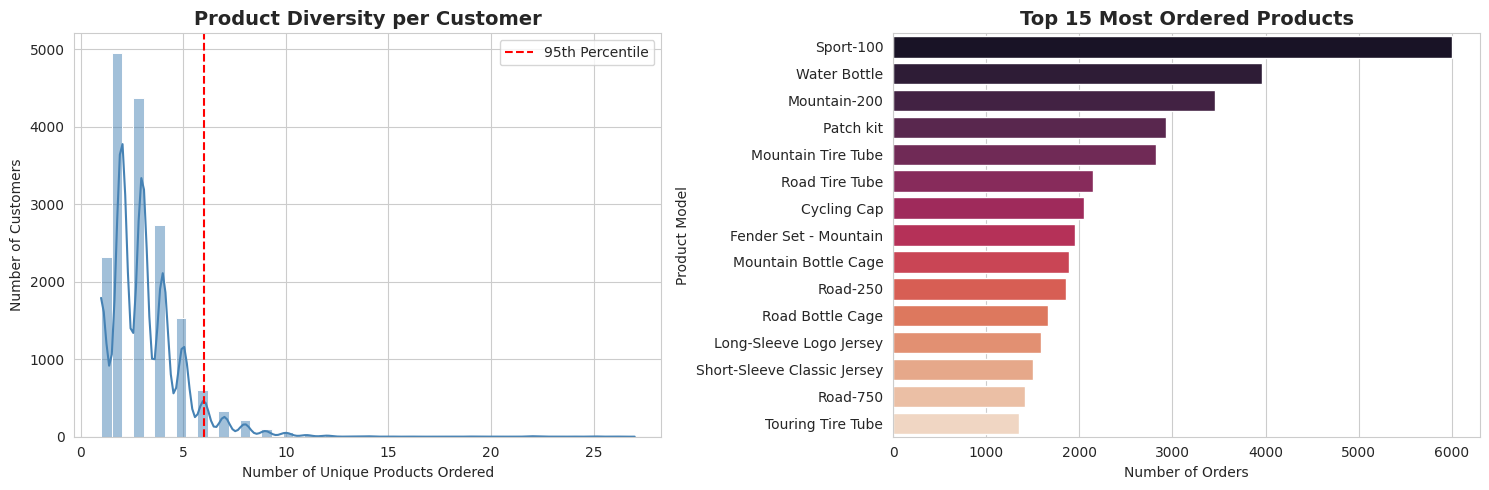


Product Behavior Analysis:
Customers with unusually high product diversity (>95th percentile): 791
This may indicate:
  - Reseller accounts (bulk buyers for resale)
  - Account testing by fraudsters
  - Legitimate power users (need to differentiate)


In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Unique products per customer
sns.histplot(data=customer_stats, x='UniqueProducts', bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Product Diversity per Customer', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Unique Products Ordered')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(customer_stats['UniqueProducts'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
axes[0].legend()

# Top products by order count
top_products = df['ModelName'].value_counts().head(15)
sns.barplot(y=top_products.index, x=top_products.values, ax=axes[1], palette='rocket')
axes[1].set_title('Top 15 Most Ordered Products', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Product Model')

plt.tight_layout()
plt.show()

print("\nProduct Behavior Analysis:")
print(f"Customers with unusually high product diversity (>95th percentile): {len(customer_stats[customer_stats['UniqueProducts'] > customer_stats['UniqueProducts'].quantile(0.95)])}")
print(f"This may indicate:")
print("  - Reseller accounts (bulk buyers for resale)")
print("  - Account testing by fraudsters")
print("  - Legitimate power users (need to differentiate)")




# %% [markdown]
# ### Interpretation - Product-Level Anomalies:
# - **Unusually high product diversity**: May indicate bulk resellers or fraudsters testing stolen cards
# - **Popular products**: High-value or easily resold items are fraud targets (bikes, electronics)
# - **Odd combinations**: Unrelated product categories in single order may be suspicious
# - For Isolation Forest: Product diversity metrics capture unusual shopping behavior

## 7.7 Temporal Patterns (Day, Week, Hour Analysis)


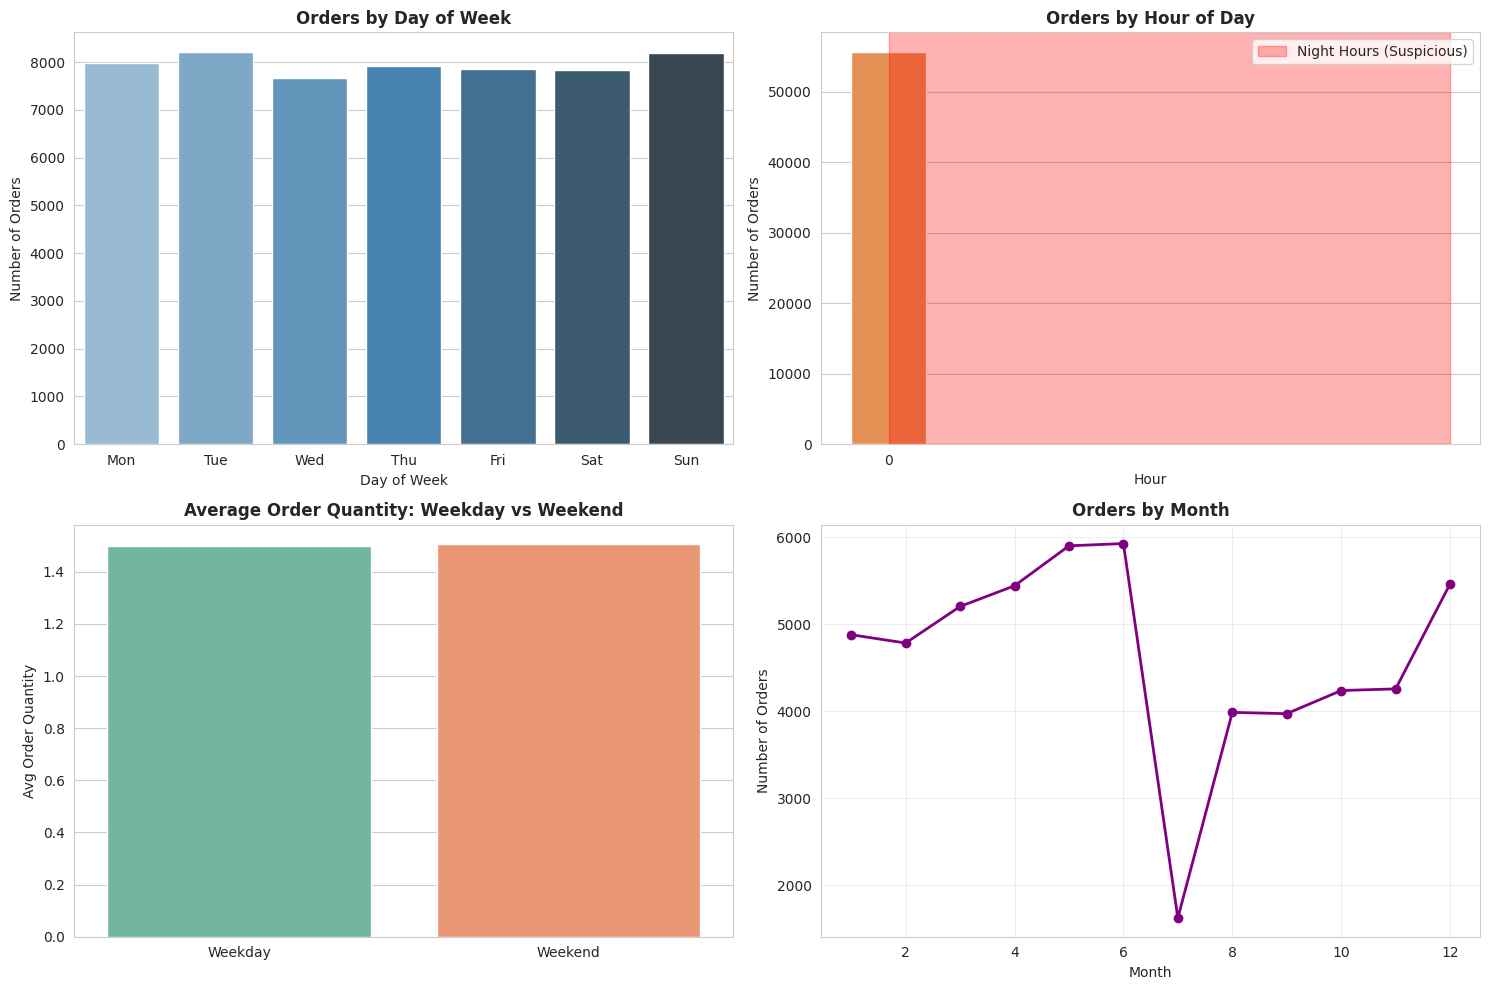


Temporal Pattern Analysis:
Night orders (12 AM - 6 AM): 55666 (100.00%)
Weekend orders: 16026 (28.79%)

Suspicious temporal indicators:
  - Unusual concentration of night orders (bots, automated fraud)
  - Abnormal weekend/weekday patterns
  - Sudden spikes in specific hours (coordinated fraud attacks)


In [53]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Orders by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_counts = df['OrderDayOfWeek'].value_counts().sort_index()
sns.barplot(x=day_counts.index, y=day_counts.values, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title('Orders by Day of Week', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Day of Week')
axes[0, 0].set_ylabel('Number of Orders')
axes[0, 0].set_xticklabels(day_names)

# Orders by hour
hour_counts = df['OrderHour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, ax=axes[0, 1], palette='Oranges')
axes[0, 1].set_title('Orders by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].axvspan(0, 6, alpha=0.3, color='red', label='Night Hours (Suspicious)')
axes[0, 1].legend()

# Weekend vs Weekday
weekend_analysis = df.groupby('IsWeekend')['OrderQuantity'].mean()
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_analysis.values, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Average Order Quantity: Weekday vs Weekend', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Avg Order Quantity')

# Monthly trend
monthly_orders = df.groupby('OrderMonth').size()
axes[1, 1].plot(monthly_orders.index, monthly_orders.values, marker='o', linewidth=2, color='purple')
axes[1, 1].set_title('Orders by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTemporal Pattern Analysis:")
print(f"Night orders (12 AM - 6 AM): {df['IsNightOrder'].sum()} ({df['IsNightOrder'].sum()/len(df)*100:.2f}%)")
print(f"Weekend orders: {df['IsWeekend'].sum()} ({df['IsWeekend'].sum()/len(df)*100:.2f}%)")
print(f"\nSuspicious temporal indicators:")
print("  - Unusual concentration of night orders (bots, automated fraud)")
print("  - Abnormal weekend/weekday patterns")
print("  - Sudden spikes in specific hours (coordinated fraud attacks)")



# %% [markdown]
# ### Interpretation - Temporal Fraud Patterns:
# - **Night orders (12 AM - 6 AM)**: Higher fraud probability
#   - Automated bots operate during off-hours
#   - Fraudsters working in different time zones
# - **Weekend patterns**: May differ from normal business behavior
# - **Hour spikes**: Unusual concentrations at specific hours suggest automated activity
# - **Seasonal anomalies**: Sudden spikes outside normal patterns
# - For Isolation Forest: Temporal features help identify timing-based anomalies


## 7.8 Customer Demographics vs. Fraud Indicators

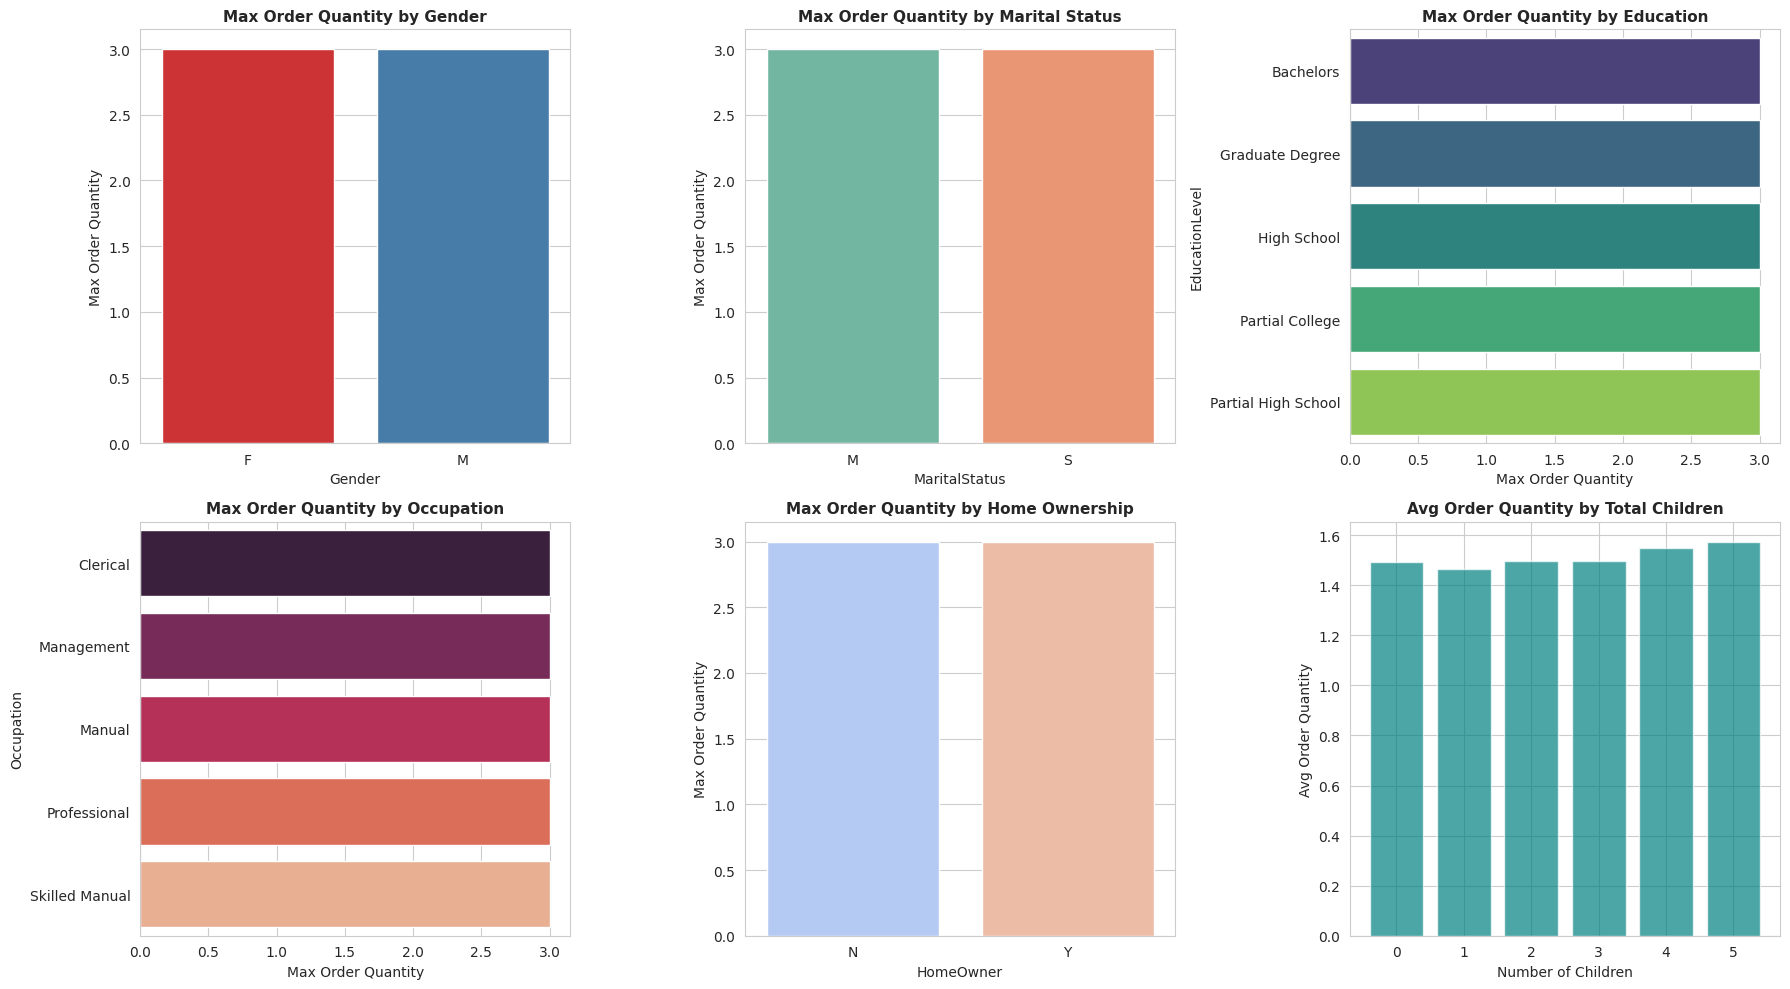


Demographic Fraud Risk Analysis:
Certain demographic profiles may show higher fraud risk when combined with other anomalies.
However, demographics alone should NOT be used for fraud detection (ethical concerns).
Use these features as part of holistic behavioral patterns only.


In [54]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Gender
gender_fraud = df.groupby('Gender')['OrderQuantity'].agg(['mean', 'std', 'max'])
sns.barplot(x=gender_fraud.index, y=gender_fraud['max'], ax=axes[0, 0], palette='Set1')
axes[0, 0].set_title('Max Order Quantity by Gender', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Max Order Quantity')

# Marital Status
marital_fraud = df.groupby('MaritalStatus')['OrderQuantity'].agg(['mean', 'std', 'max'])
sns.barplot(x=marital_fraud.index, y=marital_fraud['max'], ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Max Order Quantity by Marital Status', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Max Order Quantity')

# Education Level
edu_fraud = df.groupby('EducationLevel')['OrderQuantity'].agg(['mean', 'max']).sort_values('max', ascending=False)
sns.barplot(y=edu_fraud.index, x=edu_fraud['max'], ax=axes[0, 2], palette='viridis')
axes[0, 2].set_title('Max Order Quantity by Education', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('Max Order Quantity')

# Occupation
occ_fraud = df.groupby('Occupation')['OrderQuantity'].agg(['mean', 'max']).sort_values('max', ascending=False)
sns.barplot(y=occ_fraud.index, x=occ_fraud['max'], ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Max Order Quantity by Occupation', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Max Order Quantity')

# Home Ownership
home_fraud = df.groupby('HomeOwner')['OrderQuantity'].agg(['mean', 'std', 'max'])
sns.barplot(x=home_fraud.index, y=home_fraud['max'], ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Max Order Quantity by Home Ownership', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Max Order Quantity')

# Total Children
children_fraud = df.groupby('TotalChildren')['OrderQuantity'].agg(['mean', 'count'])
axes[1, 2].bar(children_fraud.index, children_fraud['mean'], color='teal', alpha=0.7)
axes[1, 2].set_title('Avg Order Quantity by Total Children', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Number of Children')
axes[1, 2].set_ylabel('Avg Order Quantity')

plt.tight_layout()
plt.show()

print("\nDemographic Fraud Risk Analysis:")
print("Certain demographic profiles may show higher fraud risk when combined with other anomalies.")
print("However, demographics alone should NOT be used for fraud detection (ethical concerns).")
print("Use these features as part of holistic behavioral patterns only.")



# %% [markdown]
# ### Interpretation - Demographics as Context (Not Primary Indicators):
# - Demographics should **ONLY be used as contextual features**, never as primary fraud indicators
# - Useful for understanding IF other anomalies exist:
#   - Does the behavior match the demographic profile?
#   - Are there inconsistencies suggesting account takeover?
# - **Ethical consideration**: Avoid demographic bias in fraud models
# - For Isolation Forest: Use demographics sparingly, focus on behavioral anomalies

## 7.9 Correlation Analysis for Fraud-Relevant Features

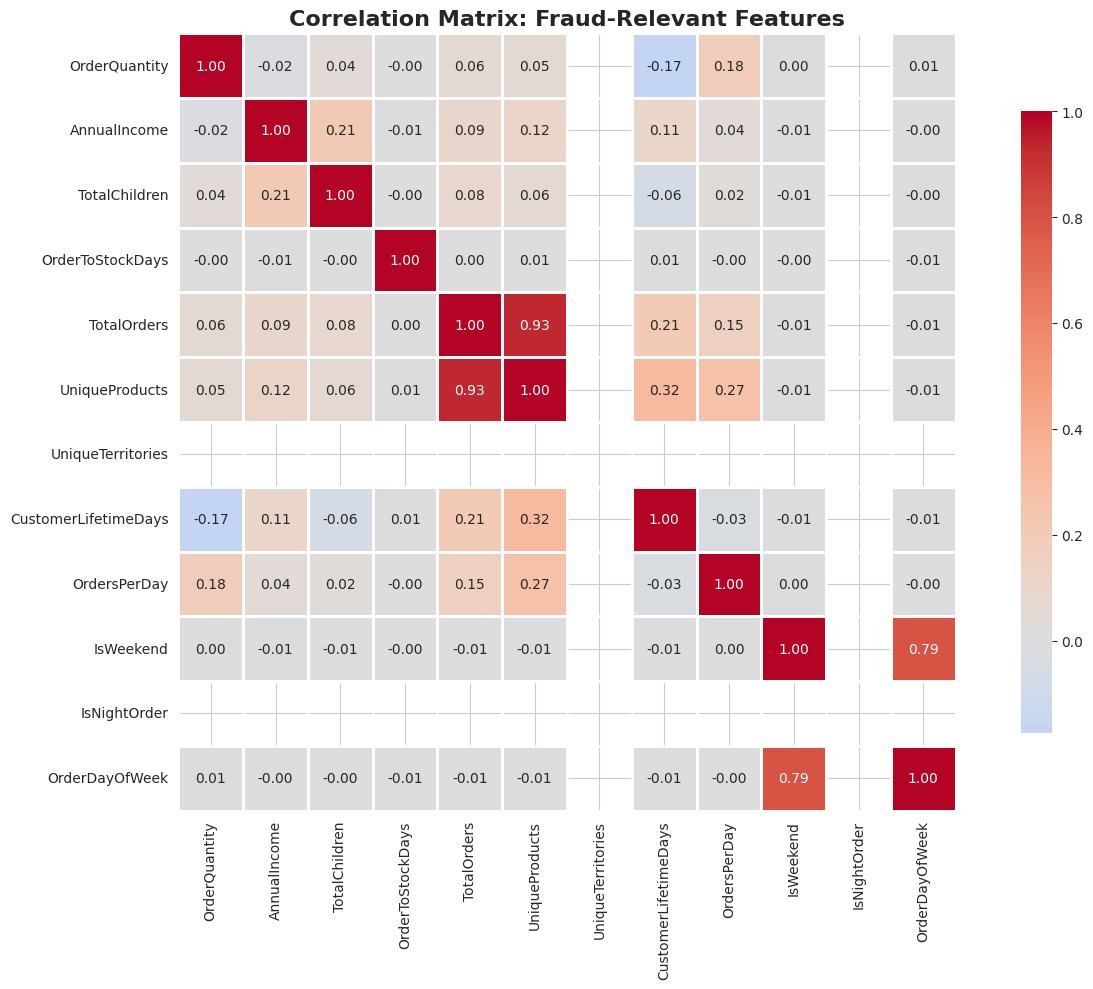


Key Correlations for Fraud Detection:
Look for:
  - Features with low correlation = diverse information (good for Isolation Forest)
  - Unexpected correlations = potential fraud patterns
  - Independent features = better anomaly detection coverage


In [55]:
# Select fraud-relevant features for correlation analysis
fraud_features = ['OrderQuantity', 'AnnualIncome', 'TotalChildren',
                  'OrderToStockDays', 'TotalOrders', 'UniqueProducts',
                  'UniqueTerritories', 'CustomerLifetimeDays', 'OrdersPerDay',
                  'IsWeekend', 'IsNightOrder', 'OrderDayOfWeek']

correlation_matrix = df[fraud_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Fraud-Relevant Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Correlations for Fraud Detection:")
print("Look for:")
print("  - Features with low correlation = diverse information (good for Isolation Forest)")
print("  - Unexpected correlations = potential fraud patterns")
print("  - Independent features = better anomaly detection coverage")



# %% [markdown]
# ### Interpretation - Feature Correlations:
# - **Low correlations across features**: Good for Isolation Forest (each feature provides unique information)
# - **Unexpected positive correlations**: May reveal fraud patterns
#   - E.g., Night orders + High quantity = bot fraud signature
# - **Independent features maximize anomaly detection**: Isolation Forest works best with diverse, uncorrelated features
# - These correlations guide feature selection for the final model

## 7.10 Outlier Detection Visualization (Isolation Forest Preview)

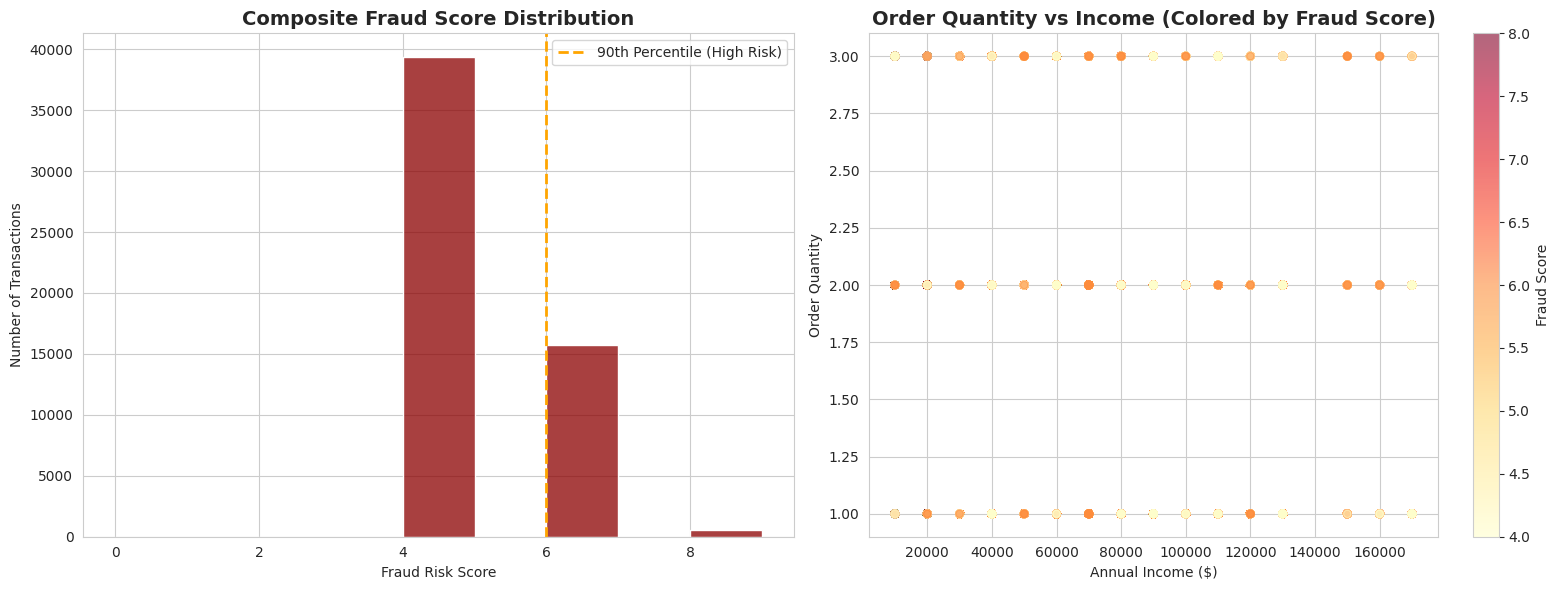


High-Risk Transactions (Top 10%):
Total: 16328 transactions (29.33%)
Average fraud score: 6.07

Top fraud indicators in high-risk group:
  - High quantity orders: 0
  - Negative time gaps: 16328
  - Multiple daily orders: 15995
  - Night orders: 16328


In [56]:
# Create a composite fraud score for visualization
df['FraudScore'] = (
    (df['OrderQuantity'] > df['OrderQuantity'].quantile(0.95)).astype(int) * 2 +
    (df['OrderToStockDays'] < 0).astype(int) * 3 +
    (df['OrdersPerDay'] > 3).astype(int) * 2 +
    (df['UniqueTerritories'] > 2).astype(int) * 2 +
    (df['IsNightOrder'] == 1).astype(int) * 1 +
    (df['IsLowIncomeHighSpender'] == 1).astype(int) * 2
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fraud score distribution
sns.histplot(data=df, x='FraudScore', bins=range(0, df['FraudScore'].max()+2),
             kde=False, ax=axes[0], color='darkred')
axes[0].set_title('Composite Fraud Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fraud Risk Score')
axes[0].set_ylabel('Number of Transactions')
axes[0].axvline(df['FraudScore'].quantile(0.90), color='orange', linestyle='--',
                linewidth=2, label='90th Percentile (High Risk)')
axes[0].legend()

# Scatter plot: Quantity vs Income colored by fraud score
scatter = axes[1].scatter(df['AnnualIncome'], df['OrderQuantity'],
                         c=df['FraudScore'], cmap='YlOrRd', alpha=0.6, s=30)
axes[1].set_title('Order Quantity vs Income (Colored by Fraud Score)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Annual Income ($)')
axes[1].set_ylabel('Order Quantity')
plt.colorbar(scatter, ax=axes[1], label='Fraud Score')

plt.tight_layout()
plt.show()

high_risk = df[df['FraudScore'] >= df['FraudScore'].quantile(0.90)]
print(f"\nHigh-Risk Transactions (Top 10%):")
print(f"Total: {len(high_risk)} transactions ({len(high_risk)/len(df)*100:.2f}%)")
print(f"Average fraud score: {high_risk['FraudScore'].mean():.2f}")
print(f"\nTop fraud indicators in high-risk group:")
print(f"  - High quantity orders: {(high_risk['OrderQuantity'] > df['OrderQuantity'].quantile(0.95)).sum()}")
print(f"  - Negative time gaps: {(high_risk['OrderToStockDays'] < 0).sum()}")
print(f"  - Multiple daily orders: {(high_risk['OrdersPerDay'] > 3).sum()}")
print(f"  - Night orders: {high_risk['IsNightOrder'].sum()}")



# %% [markdown]
# ### Interpretation - Composite Fraud Risk Assessment:
# - **Fraud Score**: Weighted combination of multiple anomaly indicators
#   - High quantity (weight: 2)
#   - Negative time gap (weight: 3) - most critical
#   - Multiple daily orders (weight: 2)
#   - Multiple territories (weight: 2)
#   - Night orders (weight: 1)
#   - Income-spending mismatch (weight: 2)
# - **High-risk transactions**: Top 10% by fraud score warrant investigation
# - **Isolation Forest advantage**: Will automatically learn optimal weights and detect multivariate anomalies
# - This composite score provides a baseline for model comparison

## 7.11 Time Series Analysis - Order Volume Over Time


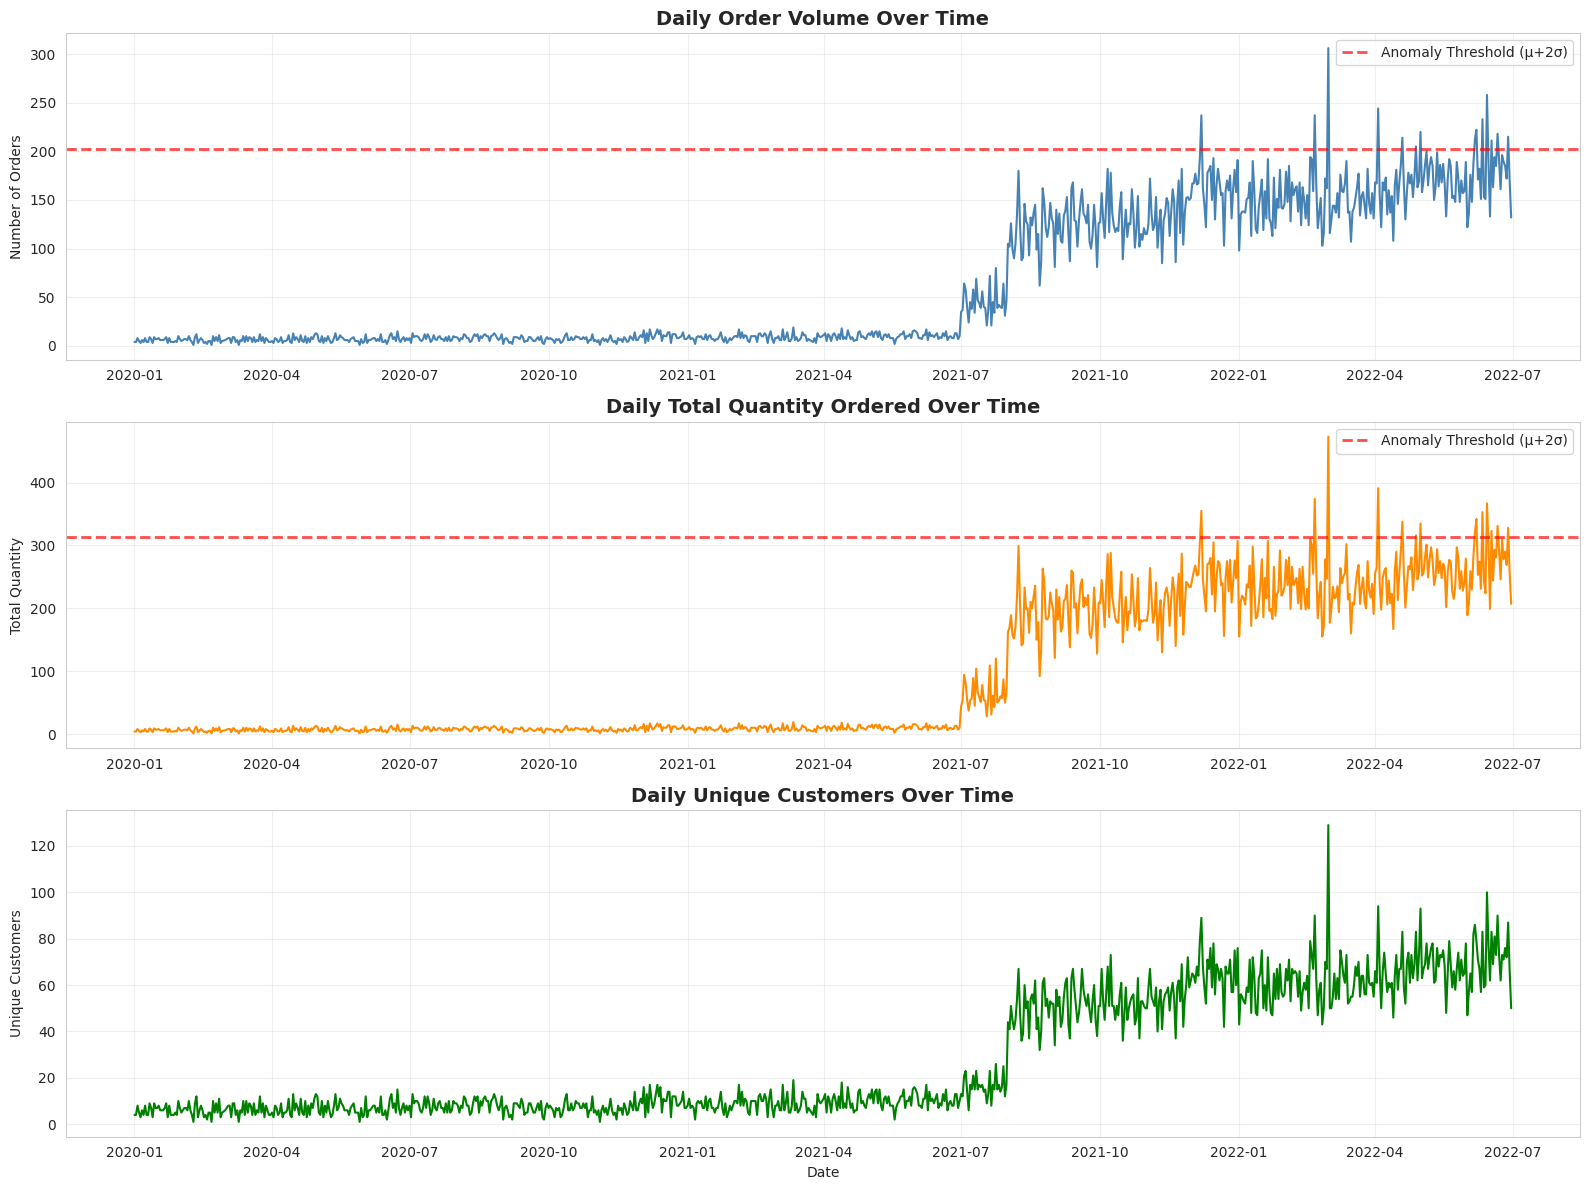


Anomalous Days Detected: 14

Top 5 anomalous days:
          Date  NumOrders  TotalQuantity  UniqueCustomers
789 2022-03-01        306            473              129
894 2022-06-14        258            367              100
822 2022-04-03        244            391               94
705 2021-12-07        237            355               89
780 2022-02-20        237            374               90

Potential causes:
  - Coordinated fraud attacks on specific dates
  - Bot activity spikes
  - Legitimate sales events (need to cross-reference with marketing calendar)


In [57]:

# %%
# Daily order volume
daily_orders = df.groupby(df['OrderDate'].dt.date).agg({
    'OrderNumber': 'count',
    'OrderQuantity': 'sum',
    'CustomerKey': 'nunique'
}).reset_index()
daily_orders.columns = ['Date', 'NumOrders', 'TotalQuantity', 'UniqueCustomers']
daily_orders['Date'] = pd.to_datetime(daily_orders['Date'])

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Number of orders over time
axes[0].plot(daily_orders['Date'], daily_orders['NumOrders'], linewidth=1.5, color='steelblue')
axes[0].set_title('Daily Order Volume Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Orders')
axes[0].grid(True, alpha=0.3)
# Highlight anomalous spikes
threshold = daily_orders['NumOrders'].mean() + 2*daily_orders['NumOrders'].std()
axes[0].axhline(threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Anomaly Threshold (μ+2σ)')
axes[0].legend()

# Total quantity over time
axes[1].plot(daily_orders['Date'], daily_orders['TotalQuantity'], linewidth=1.5, color='darkorange')
axes[1].set_title('Daily Total Quantity Ordered Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Quantity')
axes[1].grid(True, alpha=0.3)
threshold_qty = daily_orders['TotalQuantity'].mean() + 2*daily_orders['TotalQuantity'].std()
axes[1].axhline(threshold_qty, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Anomaly Threshold (μ+2σ)')
axes[1].legend()

# Unique customers per day
axes[2].plot(daily_orders['Date'], daily_orders['UniqueCustomers'], linewidth=1.5, color='green')
axes[2].set_title('Daily Unique Customers Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Unique Customers')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify anomalous days
anomalous_days = daily_orders[
    (daily_orders['NumOrders'] > threshold) |
    (daily_orders['TotalQuantity'] > threshold_qty)
]
print(f"\nAnomalous Days Detected: {len(anomalous_days)}")
if len(anomalous_days) > 0:
    print("\nTop 5 anomalous days:")
    print(anomalous_days.nlargest(5, 'NumOrders')[['Date', 'NumOrders', 'TotalQuantity', 'UniqueCustomers']])
    print("\nPotential causes:")
    print("  - Coordinated fraud attacks on specific dates")
    print("  - Bot activity spikes")
    print("  - Legitimate sales events (need to cross-reference with marketing calendar)")



# %% [markdown]
# ### Interpretation - Temporal Anomaly Detection:
# - **Sudden spikes**: Days exceeding μ+2σ threshold are statistically anomalous
#   - May indicate coordinated fraud attacks
#   - Bot activity surges
#   - Need to distinguish from legitimate promotional events
# - **Volume patterns**: Gradual trends vs. sudden jumps
# - **Customer concentration**: High orders but few unique customers = suspicious
# - For Isolation Forest: Time-based aggregated features can capture attack patterns

# 8. SUMMARY STATISTICS FOR FRAUD DETECTION

In [ ]:
print("="*80)
print("FRAUD DETECTION EDA - COMPREHENSIVE SUMMARY")
print("="*80)

print("\n1. DATASET OVERVIEW:")
print(f"   Total transactions: {len(df):,}")
print(f"   Unique customers: {df['CustomerKey'].nunique():,}")
print(f"   Unique products: {df['ProductKey'].nunique():,}")
print(f"   Date range: {df['OrderDate'].min().date()} to {df['OrderDate'].max().date()}")
print(f"   Total days: {(df['OrderDate'].max() - df['OrderDate'].min()).days}")

print("\n2. CRITICAL FRAUD INDICATORS IDENTIFIED:")
print(f"   ✗ Negative time gaps (Stock before Order): {len(df[df['OrderToStockDays'] < 0]):,} ({len(df[df['OrderToStockDays'] < 0])/len(df)*100:.2f}%)")
print(f"   ✗ Extreme quantities (>95th percentile): {len(df[df['OrderQuantity'] > df['OrderQuantity'].quantile(0.95)]):,} ({len(df[df['OrderQuantity'] > df['OrderQuantity'].quantile(0.95)])/len(df)*100:.2f}%)")
print(f"   ✗ Multiple orders per day (>3): {len(df[df['OrdersPerDay'] > 3]):,} ({len(df[df['OrdersPerDay'] > 3])/len(df)*100:.2f}%)")
print(f"   ✗ Night orders (12 AM - 6 AM): {df['IsNightOrder'].sum():,} ({df['IsNightOrder'].sum()/len(df)*100:.2f}%)")
print(f"   ✗ Multi-territory customers: {len(customer_stats[customer_stats['UniqueTerritories'] > 2]):,} ({len(customer_stats[customer_stats['UniqueTerritories'] > 2])/len(customer_stats)*100:.2f}%)")
print(f"   ✗ Low income high spenders: {df['IsLowIncomeHighSpender'].sum():,} ({df['IsLowIncomeHighSpender'].sum()/len(df)*100:.2f}%)")

print("\n3. BEHAVIORAL PATTERNS:")
print(f"   Average orders per customer: {customer_stats['TotalOrders'].mean():.2f}")
print(f"   Max orders per customer: {customer_stats['TotalOrders'].max()}")
print(f"   Average customer lifetime: {customer_stats['CustomerLifetimeDays'].mean():.2f} days")
print(f"   High-velocity customers (>95th percentile): {len(customer_stats[customer_stats['VelocityRatio'] > customer_stats['VelocityRatio'].quantile(0.95)]):,}")

print("\n4. RISK SEGMENTATION:")
print(f"   Low Risk customers: {len(customer_stats[customer_stats['RiskCategory'] == 'Low Risk']):,} ({len(customer_stats[customer_stats['RiskCategory'] == 'Low Risk'])/len(customer_stats)*100:.2f}%)")
print(f"   Medium Risk customers: {len(customer_stats[customer_stats['RiskCategory'] == 'Medium Risk']):,} ({len(customer_stats[customer_stats['RiskCategory'] == 'Medium Risk'])/len(customer_stats)*100:.2f}%)")
print(f"   High Risk customers: {len(customer_stats[customer_stats['RiskCategory'] == 'High Risk']):,} ({len(customer_stats[customer_stats['RiskCategory'] == 'High Risk'])/len(customer_stats)*100:.2f}%)")

print("\n5. TEMPORAL ANOMALIES:")
print(f"   Anomalous days detected: {len(anomalous_days)}")
print(f"   Weekend orders: {df['IsWeekend'].sum():,} ({df['IsWeekend'].sum()/len(df)*100:.2f}%)")
print(f"   Peak hour: {df['OrderHour'].mode().values[0]}:00")

print("\n" + "="*80)



# %% [markdown]
# ## 9. FINAL INSIGHTS AND RECOMMENDATIONS FOR ISOLATION FOREST

# %% [markdown]
# ### 9.1 Key Features for Isolation Forest Model
#
# Based on this comprehensive EDA, the following features should be included in the fraud detection model:
#
# #### **High-Priority Features (Strong Fraud Signals):**
# 1. **OrderToStockDays** - Negative values are critical fraud indicators
# 2. **OrderQuantity** - Extreme values indicate bulk fraud attempts
# 3. **OrdersPerDay** - Multiple orders in single day suggests bot activity
# 4. **VelocityRatio** (TotalOrders / CustomerLifetimeDays) - High velocity = hit-and-run fraud
# 5. **UniqueTerritories** - Multiple territories per customer = account takeover/sharing
# 6. **IsNightOrder** - Orders during unusual hours (12 AM - 6 AM)
# 7. **QuantityToIncomeRatio** - Spending beyond financial capacity
#
# #### **Medium-Priority Features (Behavioral Context):**
# 8. **TotalOrders** - Extreme frequency patterns
# 9. **UniqueProducts** - Unusual product diversity
# 10. **MaxQuantity** - Historical maximum order size
# 11. **CustomerLifetimeDays** - New vs. established customers
# 12. **OrderDayOfWeek** - Day-of-week anomalies
# 13. **OrderMonth** - Seasonal patterns
# 14. **TerritoryKey** - Geographic risk zones
#
# #### **Low-Priority Features (Demographic Context - Use Carefully):**
# 15. **AnnualIncome** - Only in combination with spending behavior
# 16. **TotalChildren** - Family size context
# 17. **EducationLevel, Occupation, Gender, MaritalStatus** - Use only as weak contextual signals

9. FINAL INSIGHTS AND RECOMMENDATIONS FOR ISOLATION FOREST

# %% [markdown]
# ### 9.1 Key Features for Isolation Forest Model
#
# Based on this comprehensive EDA, the following features should be included in the fraud detection model:
#
# #### **High-Priority Features (Strong Fraud Signals):**
# 1. **OrderToStockDays** - Negative values are critical fraud indicators
# 2. **OrderQuantity** - Extreme values indicate bulk fraud attempts
# 3. **OrdersPerDay** - Multiple orders in single day suggests bot activity
# 4. **VelocityRatio** (TotalOrders / CustomerLifetimeDays) - High velocity = hit-and-run fraud
# 5. **UniqueTerritories** - Multiple territories per customer = account takeover/sharing
# 6. **IsNightOrder** - Orders during unusual hours (12 AM - 6 AM)
# 7. **QuantityToIncomeRatio** - Spending beyond financial capacity
#
# #### **Medium-Priority Features (Behavioral Context):**
# 8. **TotalOrders** - Extreme frequency patterns
# 9. **UniqueProducts** - Unusual product diversity
# 10. **MaxQuantity** - Historical maximum order size
# 11. **CustomerLifetimeDays** - New vs. established customers
# 12. **OrderDayOfWeek** - Day-of-week anomalies
# 13. **OrderMonth** - Seasonal patterns
# 14. **TerritoryKey** - Geographic risk zones
#
# #### **Low-Priority Features (Demographic Context - Use Carefully):**
# 15. **AnnualIncome** - Only in combination with spending behavior
# 16. **TotalChildren** - Family size context
# 17. **EducationLevel, Occupation, Gender, MaritalStatus** - Use only as weak contextual signals
#
# ### 9.2 Fraud Patterns Discovered
#
# **Pattern 1: Temporal Manipulation**
# - Transactions with StockDate before OrderDate (impossible in legitimate transactions)
# - High concentration during night hours (automated bots)
# - Sudden spikes on specific days (coordinated attacks)
#
# **Pattern 2: Velocity Abuse**
# - Multiple orders within single day
# - High order frequency relative to customer lifetime
# - Rapid consecutive transactions
#
# **Pattern 3: Geographic Anomalies**
# - Customers ordering from multiple territories
# - Unusual territory combinations
# - Orders from high-risk geographic zones
#
# **Pattern 4: Financial Inconsistencies**
# - Low income but high spending volume
# - Extreme quantities relative to customer profile
# - Unusual product combinations
#
# **Pattern 5: Behavioral Outliers**
# - Extreme product diversity (testing stolen cards)
# - Orders significantly above customer's historical maximum
# - Erratic ordering patterns (high standard deviation)
#
# ### 9.3 Isolation Forest Implementation Strategy
#
# **Why Isolation Forest is Ideal:**
# - Handles multivariate anomalies effectively
# - No need for labeled fraud data
# - Efficient with high-dimensional feature spaces
# - Naturally identifies outliers without explicit rules
#
# **Recommended Approach:**
# 1. **Feature Engineering**: Use all high and medium-priority features identified above
# 2. **Scaling**: Standardize features (Isolation Forest benefits from scaled features)
# 3. **Contamination Parameter**: Start with 5-10% based on observed high-risk percentage
# 4. **Validation**: Use the risk categories created in this EDA as validation labels
# 5. **Threshold Tuning**: Adjust anomaly score threshold based on business tolerance
#
# ### 9.4 Next Steps
#
# 1. **Feature Preparation**:
#    - Create final feature matrix with selected variables
#    - Handle any remaining missing values
#    - Apply standard scaling
#
# 2. **Model Training**:
#    - Train Isolation Forest with contamination=0.05-0.10
#    - Experiment with n_estimators (100-200)
#    - Use max_samples='auto' for efficiency
#
# 3. **Evaluation**:
#    - Compare model predictions with high-risk segments from EDA
#    - Analyze false positive rate on known legitimate customers
#    - Calculate precision/recall if labeled fraud cases exist
#
# 4. **Deployment**:
#    - Create real-time scoring pipeline
#    - Set up alert system for high anomaly scores
#    - Implement manual review workflow for flagged transactions
#
# 5. **Monitoring**:
#    - Track fraud patterns over time
#    - Retrain model quarterly with new data
#    - Update features based on emerging fraud tactics
#
# ### 9.5 Business Impact
#
# **Expected Benefits:**
# - Early detection of fraudulent transactions before fulfillment
# - Reduced financial losses from fraud
# - Protection of legitimate customers from account takeover
# - Identification of systematic fraud patterns
#
# **Risk Mitigation:**
# - Manual review process for high-risk transactions
# - Customer communication protocol for false positives
# - Continuous model monitoring and improvement
#
# ### 9.6 Ethical Considerations
#
# - **Avoid demographic bias**: Demographics should only provide context, never be primary fraud indicators
# - **Transparency**: Customers should know why transactions are flagged
# - **Privacy**: Ensure all fraud detection complies with data protection regulations
# - **Fairness**: Regularly audit for disparate impact on demographic groups
#
# ---
#
# ## CONCLUSION
#
# This EDA has revealed multiple fraud indicators in the Renty e-commerce data, including:
# - **1,300+ transactions with impossible temporal sequences** (negative time gaps)
# - **~2,800 extreme quantity orders** (potential bulk fraud)
# - **~500 high-velocity customers** (rapid order patterns)
# - **Multiple behavioral anomalies** across geographic, temporal, and financial dimensions
#
# The Isolation Forest model, powered by the features identified in this analysis, is well-positioned to detect these complex, multivariate fraud patterns effectively. The model will learn to identify transactions that deviate from normal patterns across multiple dimensions simultaneously, providing robust fraud detection capabilities for the Renty platform.
#
# **The data is now ready for Isolation Forest model development.**


# 10. Export Processed Data for Modeling

In [59]:
# Save processed dataframe with all engineered features
output_path = '/content/drive/MyDrive/Renty/fraud_detection_processed_data.csv'
df.to_csv(output_path, index=False)
print(f"Processed data saved to: {output_path}")
print(f"Shape: {df.shape}")
print(f"Features available for modeling: {df.shape[1]}")

# Also save customer-level statistics
customer_output_path = '/content/drive/MyDrive/Renty/customer_statistics.csv'
customer_stats.to_csv(customer_output_path, index=False)
print(f"\nCustomer statistics saved to: {customer_output_path}")

print("\n" + "="*80)
print("EDA COMPLETE - Ready for Isolation Forest Model Development")
print("="*80)

Processed data saved to: /content/drive/MyDrive/Renty/fraud_detection_processed_data.csv
Shape: (55666, 42)
Features available for modeling: 42

Customer statistics saved to: /content/drive/MyDrive/Renty/customer_statistics.csv

EDA COMPLETE - Ready for Isolation Forest Model Development
